In [1]:
"""環境"""
# .lab

"""更新履歴"""
# 最終更新日：2025/05/21
# 2025/05/21 shutilを使って、cachedirを洗浄することにしました
# 2025/05/15 simple_progress_barおよびdata(dict)を使い始めました。
# 2025/02/25 os.getcwd()を採用し、__file__を定義する必要をなくしました。

"""モジュール読み込み"""
# ファイル操作等
import sys
import os
# from datetime import datetime
from pprint import pprint
import logging
# import pickle
# import struct
from tqdm import tqdm
import h5py
# import threading
import json

# tkinter
from tkinter import filedialog, messagebox, Tk

# データ分析ツール
import pandas as pd
import numpy as np
import scipy as sp
# import math
# from sklearn.linear_model import LinearRegression

# グラフ等作成用
import matplotlib
import matplotlib.pyplot as plt         # 図の作成用
from PIL import Image as im
# import cv2
from IPython.display import display, HTML, clear_output, update_display, Image

# 自作モジュール
sys.path.append(r"C:\Users\okaza\pythonenv")
from modules.Mytools.Tools import print_fileinfo, h5_tree, dict_tree, simple_progress_bar, clean_cache_except_logfiles, get_total_size
import modules.Mytools.Settings
import modules.fitXRD as fx
from modules.peakfit import peakfit, pseudoVoigt

"""ログ管理ツール作成"""
# chche directoryの設定
cachedir = os.path.abspath(os.getcwd() + "/.cache")
clean_cache_except_logfiles(cachedir)
os.makedirs(cachedir, exist_ok=True)

# loggerの作成
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
format = "%(levelname)-9s  %(asctime)s [%(filename)s:%(lineno)d] %(message)s"

# Streamハンドラクラスを作成
sh = logging.StreamHandler()
sh.setLevel(logging.DEBUG)
sh.setFormatter(logging.Formatter(format))
logger.addHandler(sh)

# Fileハンドラクラスをインスタンス化
logfile = cachedir + ""
fh = logging.FileHandler(filename=cachedir + "/notebook.log", encoding="utf-8")
fh.setLevel(logging.DEBUG)
fh.setFormatter(logging.Formatter(format))
logger.addHandler(fh)
logger.debug("[Activate workspace]: " + os.getcwd())
logger.debug("[Set cache]: "+ os.path.abspath(cachedir))
logger.debug("[Activate log]: " + os.path.abspath(cachedir + "/notebook.log"))

# globalなデータを作成
data = dict()
logger.debug("[Create global variable]: data")

DEBUG      2025-07-18 21:42:49,447 [388102471.py:71] [Activate workspace]: c:\Users\okaza\pythonenv\lf\temp_csv
DEBUG      2025-07-18 21:42:49,449 [388102471.py:72] [Set cache]: c:\Users\okaza\pythonenv\lf\temp_csv\.cache
DEBUG      2025-07-18 21:42:49,450 [388102471.py:73] [Activate log]: c:\Users\okaza\pythonenv\lf\temp_csv\.cache\notebook.log
DEBUG      2025-07-18 21:42:49,451 [388102471.py:77] [Create global variable]: data


## 目的

温度データを1次元csvに変換します

## 1. データ読み込み

hdfファイルを読み込みます

In [2]:
def read_hdf():

    # 読み込み位置
    uprange = list(range(83,85))
    downrange = list(range(290,292))

    # 読み込みファイル
    # hdffile = r""

    if True: # Main

        """変更履歴
        2025/06/25: hdffileの読み込み方法を変更しました
        """

        if not "hdffile" in locals():
            hdffile = os.path.abspath("../twocolor/.cache/hist_temp.hdf")
        key = sys._getframe().f_code.co_name
        logger.debug("[{}]: hdffile = {}".format(key, hdffile))
        with h5py.File(hdffile, mode = "r") as f:
            temp_bins = f["bins"][()] # type: ignore

            # 温度データ回収
            upstream = []
            for up in uprange:
                upstream.append(f["data"]["up_" + str(up)][()]) # type: ignore
            logger.debug("[{}]: upstream = {}".format(key, ["up_{}".format(i) for i in uprange]))
            upstream = np.stack(upstream, axis = -1)

            downstream = []
            for down in downrange:
                downstream.append(f["data"]["down_" + str(down)][()]) # type: ignore
            logger.debug("[{}]: downstream = {}".format(key, ["down_{}".format(i) for i in downrange]))
            downstream = np.stack(downstream, axis = -1)


        # データ格納
        data[key] = dict()
        data[key]["temp_bins"] = temp_bins
        data[key]["upstream"] = upstream
        data[key]["downstream"] = downstream
        logger.info("[Add variablse]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        dict_tree(data)

    return
read_hdf()
del read_hdf

DEBUG      2025-07-18 21:43:31,568 [2140117081.py:19] [read_hdf]: hdffile = c:\Users\okaza\pythonenv\lf\twocolor\.cache\hist_temp.hdf


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'c:\Users\okaza\pythonenv\lf\twocolor\.cache\hist_temp.hdf', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## 2. 1次元化

温度を計算します。

### 2-1. 上流

DEBUG      2025-06-27 10:20:13,411 [3313536909.py:82] [Save fig]: c:\Users\okaza\pythonenv\lf\temp_csv\.cache\stream_upstream.png
INFO       2025-06-27 10:20:13,412 [3313536909.py:93] [Add variables]: stream_upstream (data = 2.44 MB)


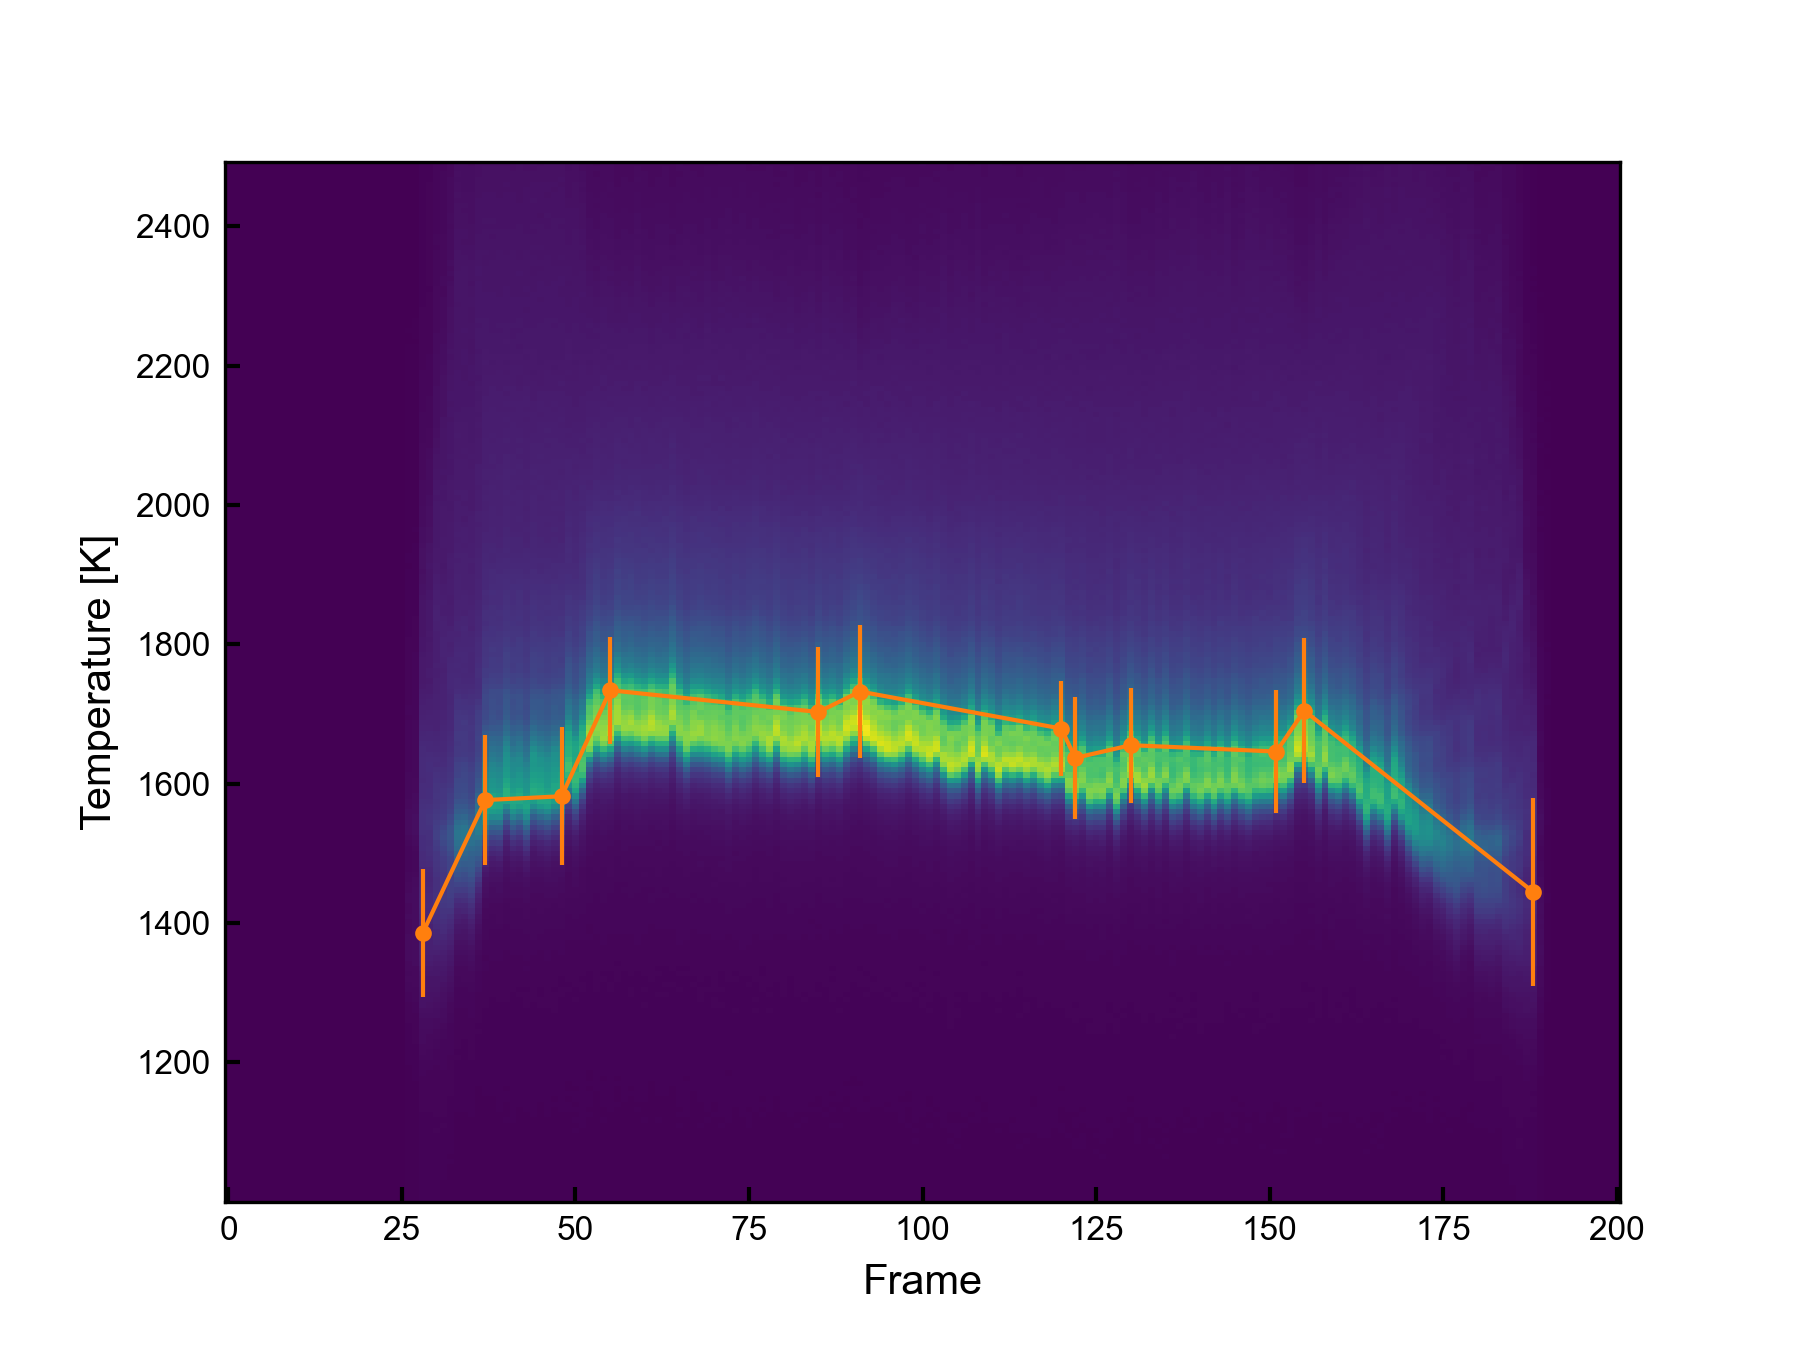


├── read_hdf
│   ├── temp_bins <class 'numpy.ndarray'> [shape = (199,)]
│   ├── upstream <class 'numpy.ndarray'> [shape = (201, 199, 4)]
│   └── downstream <class 'numpy.ndarray'> [shape = (201, 199, 4)]
└── stream_upstream
    └── anchor <class 'numpy.ndarray'> [shape = (3, 12)]

In [6]:
def stream():

    # stream
    stream = "upstream"

    # frame range
    # frame_lim = (0,20)

    # temperature range (option)
    # temp_lim = (1000, 2500)

    # anchors
    if True:
        anchor = [
            [	28 	,	1385.7434 	,	91.6497 	],
            [	37 	,	1576.3747 	,	93.4827 	],
            [	48 	,	1581.8737 	,	98.9817 	],
            [	55 	,	1734.0122 	,	76.9857 	],
            [	85 	,	1702.8513 	,	93.4827 	],
            [	91 	,	1732.1792 	,	95.3157 	],
            [	120 	,	1679.0224 	,	67.8208 	],
            [	122 	,	1636.8635 	,	87.9837 	],
            [	130 	,	1655.1935 	,	82.4847 	],
            [	151 	,	1646.0285 	,	87.9837 	],
            [	155 	,	1704.6843 	,	104.4807 	],
            [	188 	,	1444.3992 	,	135.6415 	],
        ]

    if True: # [ Main ]

        """更新履歴
        * 2025/06/24 画像の保存ファイル名を変更
        """

        # データ読み込み
        st = np.sum(data["read_hdf"][stream], axis = -1).T
        temp = data["read_hdf"]["temp_bins"]
        temp_step = (max(temp)-min(temp))/len(temp)

        # fig作成
        fig, ax = plt.subplots()
        fig.set_size_inches((6,4.5))
        fig.set_dpi(300)

        ax.imshow(
            st,
            aspect = "auto",
            origin = "lower",
            extent = [-0.5, st.shape[1]-0.5, temp[0]-temp_step/2, temp[-1]-temp_step/2], # type: ignore
        )

        if "anchor" in locals():
            anchor = np.array(anchor).T # type: ignore
            ax.errorbar(
                anchor[0],
                anchor[1],
                yerr = anchor[2],
                lw = 1,
                marker = "o",
                ms = 3,
                color = "tab:orange"
            )

        if "frame_lim" in locals():
            ax.set_xlim(frame_lim) # type: ignore
        if "temp_lim" in locals():
            ax.set_ylim(temp_lim) # type: ignore
        ax.set_xlabel("Frame", fontsize = 10)
        ax.set_ylabel("Temperature [K]", fontsize = 10)

        # 画像の保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}_{}.png".format(key, stream)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # # データ格納
        key = sys._getframe().f_code.co_name + "_" + stream
        data[key] = dict()
        if "anchor" in locals():
            data[key]["anchor"] = anchor
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

        # 出力
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)

    return
stream()
del stream

データを作成します。

In [7]:
def interp_temp():

    stream = "upstream"

    frame = np.arange(data["read_hdf"]["upstream"].shape[0])
    temp1d = np.ones(frame.shape) * 300
    err1d = np.zeros(frame.shape)

    anchor = data["stream" + "_" + stream]["anchor"]
    xlim = (int(anchor[0,0]), int(anchor[0,-1])+1)

    interp = sp.interpolate.interp1d(
        x = anchor[0],
        y = anchor[1],
        kind = "linear"
    )
    temp1d[xlim[0]:xlim[1]] = interp(np.arange(*xlim))

    einterp = sp.interpolate.interp1d(
        x = anchor[0],
        y = anchor[2],
        kind = "linear"
    )
    err1d[xlim[0]:xlim[1]] = einterp(np.arange(*xlim))

    # # データ格納
    key = sys._getframe().f_code.co_name + "_" + stream
    data[key] = dict()
    data[key]["frame"] = frame
    data[key]["temp"] = temp1d
    data[key]["err"] = err1d
    logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

    # 出力
    dict_tree(data)

    return
interp_temp()
del interp_temp

INFO       2025-06-27 10:20:35,488 [2827828182.py:32] [Add variables]: interp_temp_upstream (data = 2.45 MB)



├── read_hdf
│   ├── temp_bins <class 'numpy.ndarray'> [shape = (199,)]
│   ├── upstream <class 'numpy.ndarray'> [shape = (201, 199, 4)]
│   └── downstream <class 'numpy.ndarray'> [shape = (201, 199, 4)]
├── stream_upstream
│   └── anchor <class 'numpy.ndarray'> [shape = (3, 12)]
└── interp_temp_upstream
    ├── frame <class 'numpy.ndarray'> [shape = (201,)]
    ├── temp <class 'numpy.ndarray'> [shape = (201,)]
    └── err <class 'numpy.ndarray'> [shape = (201,)]

### 2-2. 下流

DEBUG      2025-06-27 10:23:56,894 [1292310838.py:84] [Save fig]: c:\Users\okaza\pythonenv\lf\temp_csv\.cache\stream_downstream.png
INFO       2025-06-27 10:23:56,895 [1292310838.py:95] [Add variables]: stream_downstream (data = 2.45 MB)


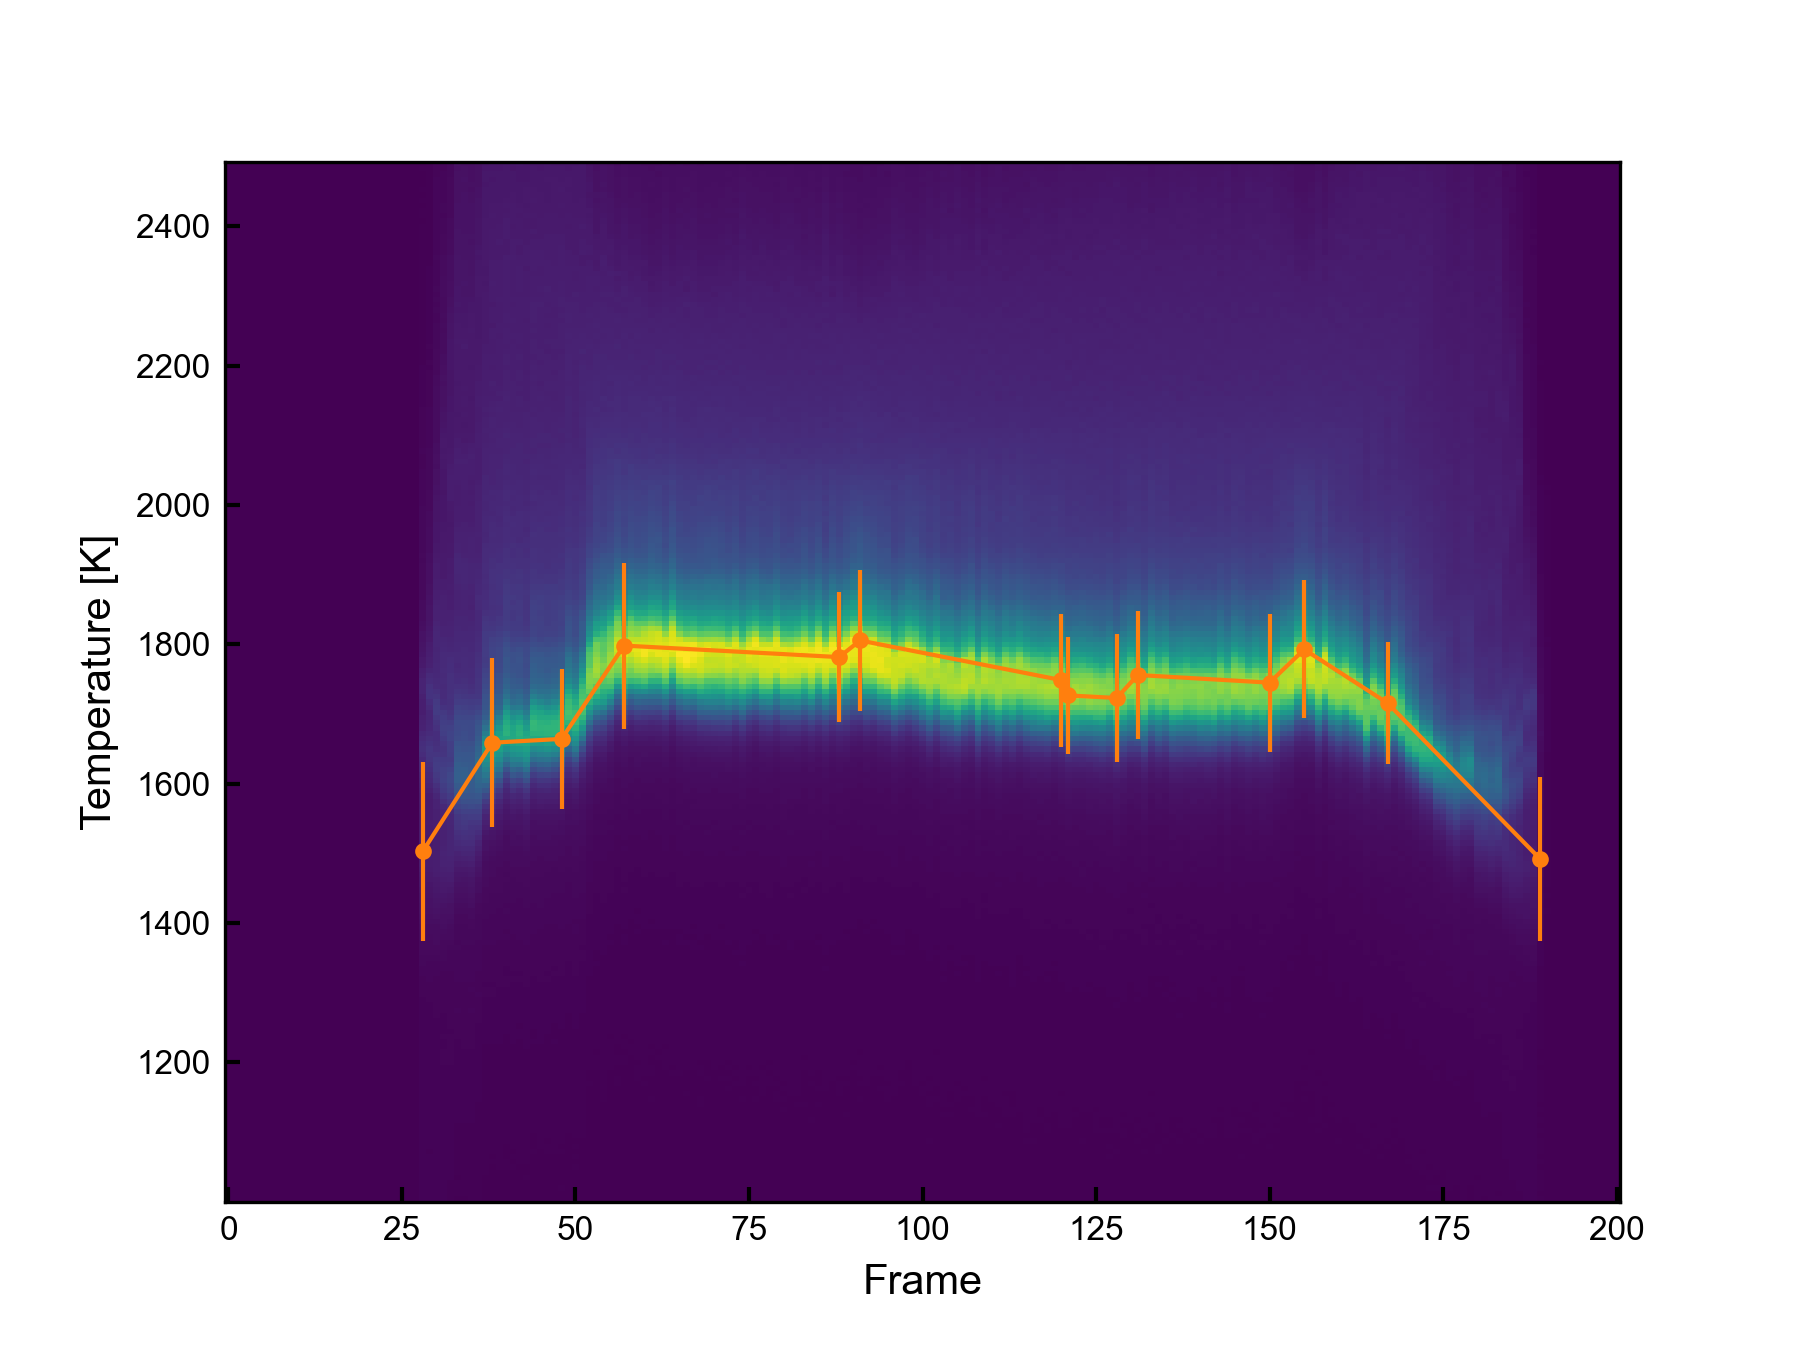


├── read_hdf
│   ├── temp_bins <class 'numpy.ndarray'> [shape = (199,)]
│   ├── upstream <class 'numpy.ndarray'> [shape = (201, 199, 4)]
│   └── downstream <class 'numpy.ndarray'> [shape = (201, 199, 4)]
├── stream_upstream
│   └── anchor <class 'numpy.ndarray'> [shape = (3, 12)]
├── interp_temp_upstream
│   ├── frame <class 'numpy.ndarray'> [shape = (201,)]
│   ├── temp <class 'numpy.ndarray'> [shape = (201,)]
│   └── err <class 'numpy.ndarray'> [shape = (201,)]
└── stream_downstream
    └── anchor <class 'numpy.ndarray'> [shape = (3, 14)]

In [10]:
def stream():

    # stream
    stream = "downstream"

    # frame range
    # frame_lim = (0,20)

    # temperature range
    # temp_lim = (250, 2500)

    # anchors
    if True:
        anchor = [
            [	28 	,	1502.7523 	,	128.4404 	],
            [	38 	,	1658.7156 	,	121.1009 	],
            [	48 	,	1664.2202 	,	100.9174 	],
            [	57 	,	1798.1651 	,	119.2661 	],
            [	88 	,	1781.6514 	,	93.5780 	],
            [	91 	,	1805.5046 	,	100.9174 	],
            [	120 	,	1748.6239 	,	95.4128 	],
            [	121 	,	1726.6055 	,	84.4037 	],
            [	128 	,	1722.9358 	,	91.7431 	],
            [	131 	,	1755.9633 	,	91.7431 	],
            [	150 	,	1744.9541 	,	99.0826 	],
            [	155 	,	1792.6606 	,	99.0826 	],
            [	167 	,	1715.5963 	,	88.0734 	],
            [	189 	,	1491.7431 	,	117.4312 	],
        ]

    if True: # [ Main ]

        """更新履歴
        * 2025/06/24 画像の保存ファイル名を変更
        """

        # データ読み込み
        st = np.sum(data["read_hdf"][stream], axis = -1).T
        temp = data["read_hdf"]["temp_bins"]
        temp_step = (max(temp)-min(temp))/len(temp)

        # fig作成
        fig, ax = plt.subplots()
        fig.set_size_inches((6,4.5))
        fig.set_dpi(300)

        ax.imshow(
            st,
            aspect = "auto",
            origin = "lower",
            extent = [-0.5, st.shape[1]-0.5, temp[0]-temp_step/2, temp[-1]-temp_step/2], # type: ignore
        )

        if "anchor" in locals():
            anchor = np.array(anchor).T # type: ignore
            ax.errorbar(
                anchor[0],
                anchor[1],
                yerr = anchor[2],
                lw = 1,
                marker = "o",
                ms = 3,
                color = "tab:orange"
            )

        if "frame_lim" in locals():
            ax.set_xlim(frame_lim) # type: ignore
        if "temp_lim" in locals():
            ax.set_ylim(temp_lim) # type: ignore
        ax.set_xlabel("Frame", fontsize = 10)
        ax.set_ylabel("Temperature [K]", fontsize = 10)

        # 画像の保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}_{}.png".format(key, stream)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # # データ格納
        key = sys._getframe().f_code.co_name + "_" + stream
        data[key] = dict()
        if "anchor" in locals():
            data[key]["anchor"] = anchor
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

        # 出力
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)

    return
stream()
del stream

データを作成します。

In [11]:
def interp_temp():

    stream = "downstream"

    frame = np.arange(data["read_hdf"]["upstream"].shape[0])
    temp1d = np.ones(frame.shape) * 300
    err1d = np.zeros(frame.shape)

    anchor = data["stream" + "_" + stream]["anchor"]
    xlim = (int(anchor[0,0]), int(anchor[0,-1])+1)

    interp = sp.interpolate.interp1d(
        x = anchor[0],
        y = anchor[1],
        kind = "linear"
    )
    temp1d[xlim[0]:xlim[1]] = interp(np.arange(*xlim))

    einterp = sp.interpolate.interp1d(
        x = anchor[0],
        y = anchor[2],
        kind = "linear"
    )
    err1d[xlim[0]:xlim[1]] = einterp(np.arange(*xlim))

    # # データ格納
    key = sys._getframe().f_code.co_name + "_" + stream
    data[key] = dict()
    data[key]["frame"] = frame
    data[key]["temp"] = temp1d
    data[key]["err"] = err1d
    logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

    # 出力
    dict_tree(data)

    return
interp_temp()
del interp_temp

INFO       2025-06-27 10:24:04,373 [1559966353.py:32] [Add variables]: interp_temp_downstream (data = 2.45 MB)



├── read_hdf
│   ├── temp_bins <class 'numpy.ndarray'> [shape = (199,)]
│   ├── upstream <class 'numpy.ndarray'> [shape = (201, 199, 4)]
│   └── downstream <class 'numpy.ndarray'> [shape = (201, 199, 4)]
├── stream_upstream
│   └── anchor <class 'numpy.ndarray'> [shape = (3, 12)]
├── interp_temp_upstream
│   ├── frame <class 'numpy.ndarray'> [shape = (201,)]
│   ├── temp <class 'numpy.ndarray'> [shape = (201,)]
│   └── err <class 'numpy.ndarray'> [shape = (201,)]
├── stream_downstream
│   └── anchor <class 'numpy.ndarray'> [shape = (3, 14)]
└── interp_temp_downstream
    ├── frame <class 'numpy.ndarray'> [shape = (201,)]
    ├── temp <class 'numpy.ndarray'> [shape = (201,)]
    └── err <class 'numpy.ndarray'> [shape = (201,)]

### 2-3. 可視化

結果を可視化します。

DEBUG      2025-06-27 10:24:12,607 [3372483859.py:39] [Save fig]: c:\Users\okaza\pythonenv\lf\temp_csv\.cache\plot_eacnstream.png


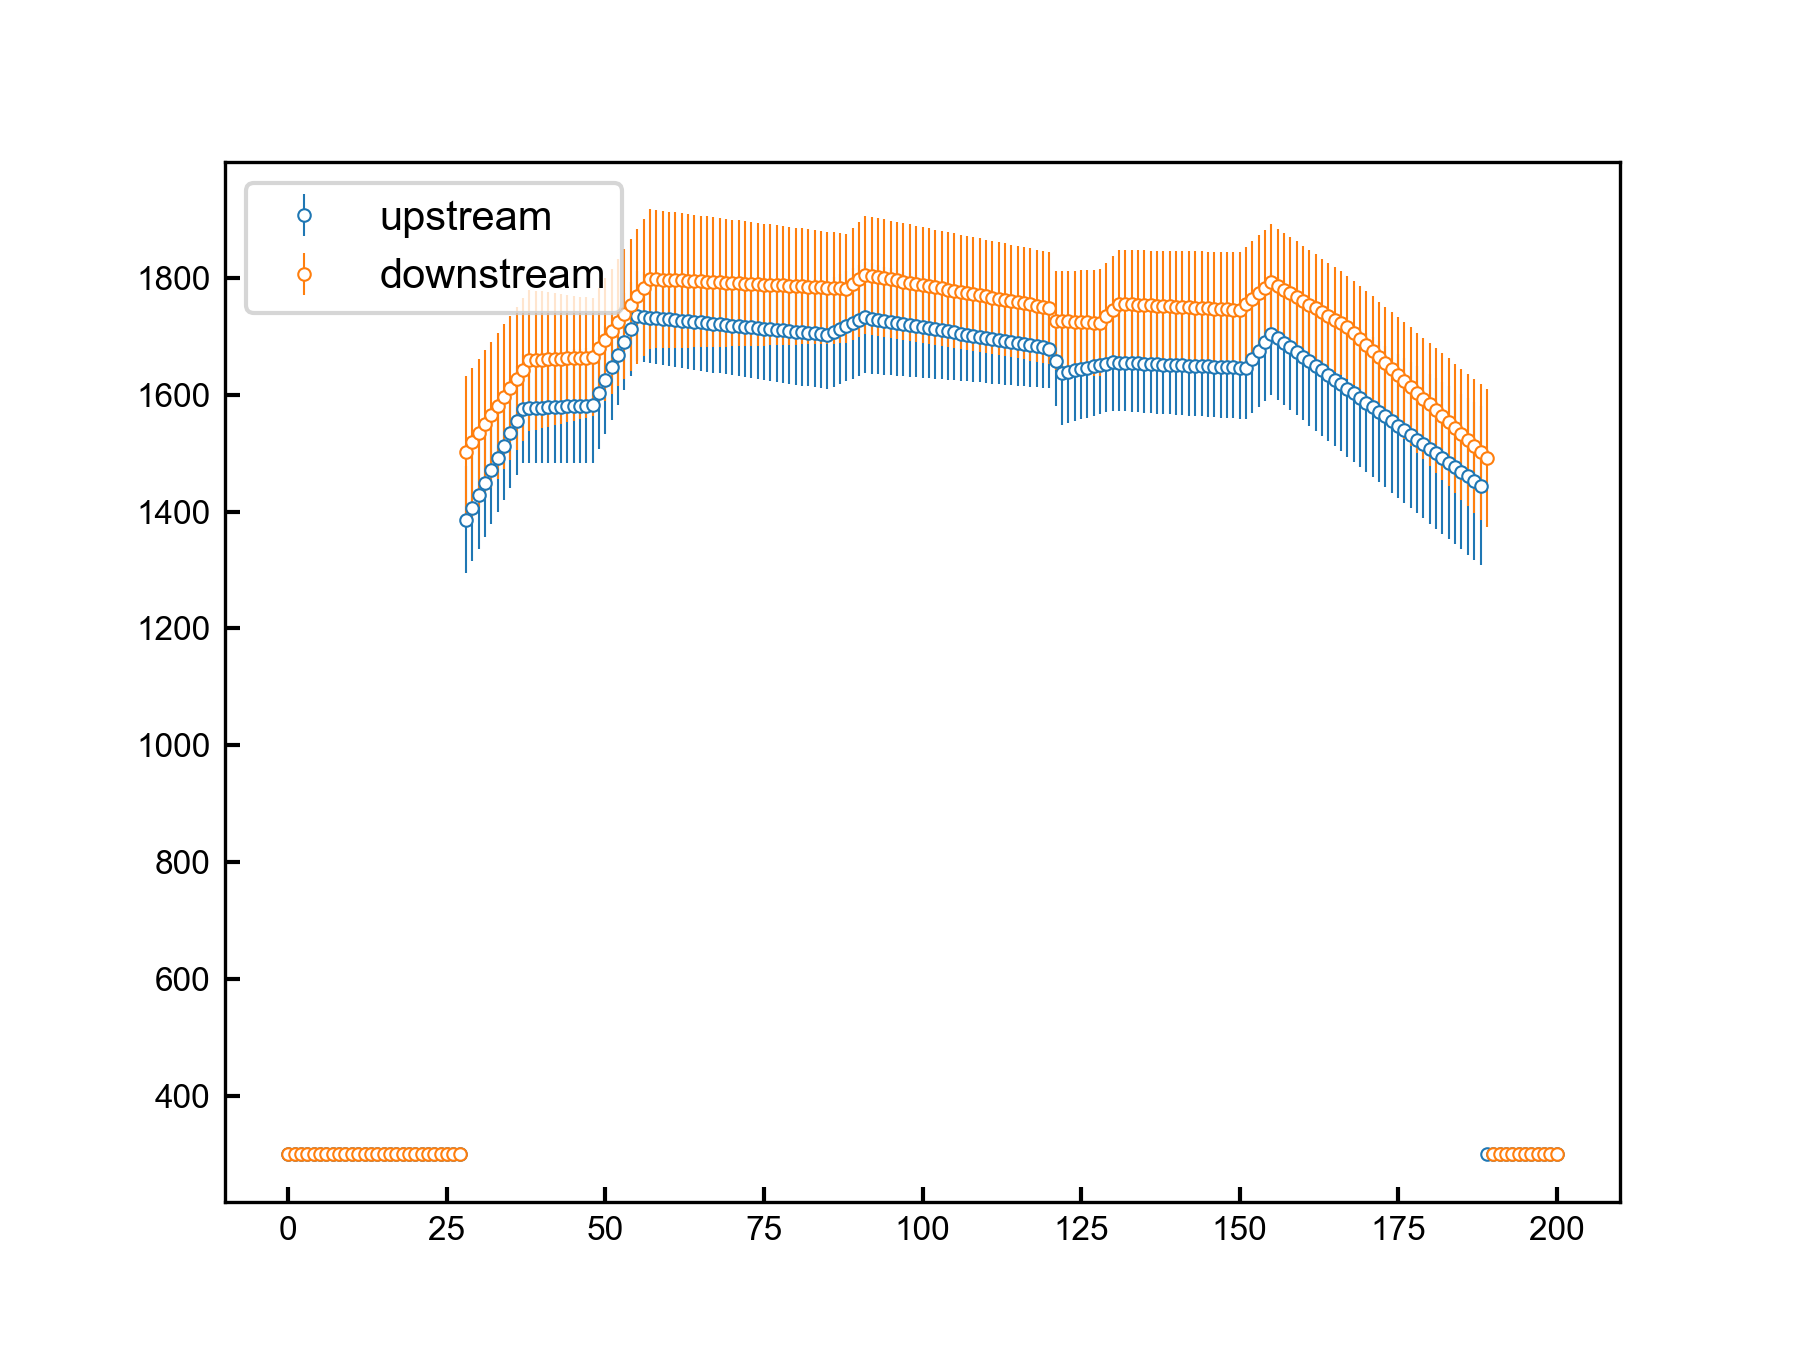

In [12]:
def plot_eacnstream():

    # データ読み込み
    frame = data["interp_temp_upstream"]["frame"]

    # fig作成
    fig, ax = plt.subplots()
    fig.set_size_inches((6,4.5))
    fig.set_dpi(300)

    for stream, color in zip(["upstream", "downstream"], ["tab:blue", "tab:orange"]):
        ax.errorbar(
            x = frame,
            y = data["interp_temp_" + stream]["temp"],
            yerr = data["interp_temp_" + stream]["err"],
            marker = "o",
            lw = 0,
            markersize = 3,
            mfc = "1",
            mew = 0.5,
            mec = color,
            elinewidth=0.5,
            ecolor = color,
            label = stream
        )
    ax.legend(fontsize = 10)

    # 画像の保存
    fig.canvas.draw()
    img = im.frombuffer(
        mode = "RGBA",
        size = fig.canvas.get_width_height(),
        data = fig.canvas.buffer_rgba(), # type: ignore
        decoder_name = "raw"
    )
    key = sys._getframe().f_code.co_name
    imgfilename = cachedir + "/{}.png".format(key)
    img.save(imgfilename)
    logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
    # pdffilename = cachedir + "/{}.pdf".format(key)
    # plt.savefig(pdffilename)
    # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
    plt.close()

    # 出力
    display(Image(filename = imgfilename, width = 600))

plot_eacnstream()
del plot_eacnstream

## 3. データ保存

csvに変換してデータを保存します。

In [13]:
def save_csv():

    # データ読み込み
    temp = np.vstack(
        [data["interp_temp_{}stream".format(st)]["temp"] for st in ["up", "down"]]
    )
    err = np.vstack(
        [data["interp_temp_{}stream".format(st)]["err"] for st in ["up", "down"]]
    )

    # fps
    jsonfile = r"C:\Users\okaza\pythonenv\lf\dist\.cache\show_metadata.json"
    with open(jsonfile, mode = "r") as f:
        meta = json.load(f)
    fps = float(meta["SpeFormat"]["DataHistories"]["DataHistory"]["Origin"]["Experiment"]["Devices"]["Cameras"]["Camera"]["Acquisition"]["FrameRate"])
    t = np.arange(temp.shape[1])/fps

    # データ作成
    weight = err.copy()
    weight[err == 0] = 1
    weight = np.reciprocal(weight)
    temp_1d = np.average(temp, axis = 0, weights=weight)
    err_1d = np.average(err, axis = 0, weights = weight)
    
    # データ保存
    csv = pd.DataFrame(
        np.vstack([
            t,
            temp_1d,
            err_1d,
        ]).T
    )
    csv.columns = ["Time [s]","Temperature [K]", "err [K]"]
    key = sys._getframe().f_code.co_name
    csvfilename = os.path.join(cachedir, key + ".csv")
    csv.to_csv(csvfilename)
    logger.debug(f"[{key}]: {csvfilename}")

    display(csv)



    return
save_csv()
del save_csv

DEBUG      2025-06-27 10:24:18,255 [1571087549.py:37] [save_csv]: c:\Users\okaza\pythonenv\lf\temp_csv\.cache\save_csv.csv


,Time [s],Temperature [K],err [K]
0,0.000000,300.000000,0.000000
1,1.079336,300.000000,0.000000
2,2.158671,300.000000,0.000000
3,3.238007,300.000000,0.000000
4,4.317342,300.000000,0.000000
5,5.396678,300.000000,0.000000
6,6.476013,300.000000,0.000000
7,7.555349,300.000000,0.000000
8,8.634684,300.000000,0.000000
9,9.714020,300.000000,0.000000
